In [1]:
!git clone https://github.com/AvonYangXX1/AMPLify-Feedback.git
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Cloning into 'AMPLify-Feedback'...
remote: Enumerating objects: 494, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 494 (delta 72), reused 131 (delta 67), pack-reused 351
Receiving objects: 100% (494/494), 246.83 MiB | 32.72 MiB/s, done.
Resolving deltas: 100% (239/239), done.
Updating files: 100% (96/96), done.


In [2]:
generator = tf.keras.models.load_model('AMPLify-Feedback/model_weights/PeptideGenerator_new.keras')

In [3]:
def create_oracle():
    inputs0 = tf.keras.layers.Input((190,43),name="SeqInput")
    inputs1 = tf.keras.layers.Input((326,),name="StateInput")
    x = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_0")(inputs0) # kernel_size=5 works well
    x = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_1")(x) # Just two layers work better
    x = tf.keras.layers.Flatten(name="Flatten_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="LearnSeqDense_0")(x)
    x = tf.keras.layers.Concatenate(axis=1, name="Concat")([x, inputs1])
    x = tf.keras.layers.Dense(1024, activation="relu", name="LearnConcatDense_0")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="LearnConcatDense_1")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_1")(x)
    x = tf.keras.layers.Dense(1, activation="linear", name="Output")(x)
    model = tf.keras.models.Model([inputs0, inputs1], x, name="MICPredictor")
    return model

In [4]:
oracle = create_oracle()
path = "AMPLify-Feedback/model_weights/MICPredictor"
for i, layer in enumerate(oracle.layers):
    weights = np.load(f"{path}/layer_{i}_weights.npy", allow_pickle=True)
    layer.set_weights(weights)

In [5]:
aa_vocal = np.load("AMPLify-Feedback/model_weights/SeqTV_vocal.npy")
pep_decoder = tf.keras.layers.StringLookup(vocabulary=aa_vocal[1:], invert=True, oov_token='')
species_vocal = np.load("AMPLify-Feedback/model_weights/SpeciesTV_vocal.npy")
species_decoder = tf.keras.layers.StringLookup(vocabulary=species_vocal[1:], invert=True, oov_token='')

In [6]:
species_vocal

array(['[UNK]', 'Bacillus_subtilis', 'Staphylococcus_aureus',
       'Escherichia_coli', 'Pseudomonas_aeruginosa', 'Candida_albicans',
       'Pectobacterium_carotovorum', 'Clavibacter_michiganensis',
       'Pseudomonas_corrugata', 'Pseudomonas_syringae',
       'Xanthomonas_vesicatoria', 'Klebsiella_pneumoniae',
       'Staphylococcus_epidermidis', 'Candida_parapsilosis',
       'Micrococcus_luteus', 'Enterococcus_faecium',
       'Enterobacter_cloacae', 'Acinetobacter_baumannii',
       'Bacillus_anthracis', 'Staphylococcus_saprophyticus',
       'Proteus_mirabilis', 'Proteus_vulgaris', 'Salmonella_typhimurium',
       'Saccharomyces_cerevisiae', 'Listonella_anguillarum',
       'Enterobacter_aerogenes', 'Providencia_stuartii',
       'Candida_tropicalis', 'Candida_krusei', 'Salmonella_enterica',
       'Streptococcus_pneumoniae', 'Shigella_sonnei',
       'Enterococcus_faecalis', 'Neisseria_gonorrhoeae',
       'Streptococcus_agalactiae', 'Malassezia_furfur',
       'Trichophyton_m

In [7]:
def onehot2seq(onehot):
    demo_seq = tf.math.argmax(onehot, axis=2)
    demo_seq = pep_decoder(demo_seq).numpy().astype('str')
    demo_seq = ["".join(chars) for chars in demo_seq]
    return demo_seq

In [8]:
# Grid search coordinates
num_bins = 101
labels = np.round(np.linspace(-1, 1, num_bins), 2)
noise = []
for x in labels:
    for y in labels:
        noise.append([x, y])
noise = np.array(noise)
num_sequences = len(noise)

# Look up the index of the target bacteria
target = 'Bacillus_subtilis'
bacteria = np.zeros(shape=(num_sequences, 326))
index = np.where(species_vocal==target)[0][0]
bacteria[:, index] = 1

# Generate sequences and predict MIC
generated_onehot = generator.predict(noise, verbose=0)
MIC = oracle.predict([generated_onehot, bacteria], verbose=0)
generated_sequences = onehot2seq(generated_onehot)
vis_data = np.concatenate([noise, np.array(generated_sequences).reshape(num_sequences, 1), MIC], axis=1)
vis_data = pd.DataFrame(vis_data, columns=["Noise_1", "Noise_2", "Peptide", "MIC"])
vis_data['MIC'] = vis_data['MIC'].astype('float64')
vis_data['Noise_1'] = vis_data['Noise_1'].astype('float64')
vis_data['Noise_2'] = vis_data['Noise_2'].astype('float64')

In [9]:
vis_data

,Noise_1,Noise_2,Peptide,MIC
0,-1.0,-1.00,VA,2.652224
1,-1.0,-0.98,VA,2.652224
2,-1.0,-0.96,VA,2.652224
3,-1.0,-0.94,VA,2.652224
4,-1.0,-0.92,VA,2.652224
...,...,...,...,...
10196,1.0,0.92,ADTYFDDLKP,5.039650
10197,1.0,0.94,ADTYFDDLKP,5.109775
10198,1.0,0.96,ADTYFDDLKP,5.194454
10199,1.0,0.98,ADTYFDDLKP,5.284733


In [15]:
vis_data.nsmallest(1000, "MIC")

,Noise_1,Noise_2,Peptide,MIC
10135,1.00,-0.30,EVGAkDGKkKRLKK,1.608211
10034,0.98,-0.30,EVGAkDGKkKRLKK,1.614914
10134,1.00,-0.32,EVGAkDGKkKRLKK,1.631229
9933,0.96,-0.30,EVGAkDGKkKRLKK,1.631647
9833,0.94,-0.28,EVGAkDGKkKRLKK,1.634527
...,...,...,...,...
533,-0.90,-0.44,VADI,2.573792
1034,-0.80,-0.52,DADI,2.574082
2135,-0.58,-0.72,VAI,2.574855
2139,-0.58,-0.64,DADI,2.574943


In [12]:
from Bio.Align import PairwiseAligner
from Bio.Align import substitution_matrices

def calculate_blosum62_score(seq1, seq2):
    aligner = PairwiseAligner()
    aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
    aligner.open_gap_score = -10
    aligner.extend_gap_score = -0.5
    score = aligner.score(seq1, seq2)  # Get the best score
    return score

In [14]:
amp0_data =pd.read_csv("/content/AMPLify-Feedback/source_data/AMP0_data.csv")
amp0_data

,DBAASP ID,C-terminus modification,N-terminus modification,Sequence,Target species,MIC (?g/mL )
0,4446,#,#,GLPRKILCAIAKKKGKAKGPLKLVCKA,Bacillus subtilis,1.416819
1,4446,#,#,GLPRKILCAIAKKKGKAKGPLKLVCKA,Staphylococcus aureus,283.363770
2,4446,#,#,GLPRKILCAIAKKKGKAKGPLKLVCKA,Escherichia coli,155.850074
3,4446,#,#,GLPRKILCAIAKKKGKAKGPLKLVCKA,Pseudomonas aeruginosa,184.186451
4,4446,#,#,GLPRKILCAIAKKKGKAKGPLKLVCKA,Candida albicans,198.354639
...,...,...,...,...,...,...
30707,4444,#,#,GLPRKILCAIAKKKGKCKGPLKLVCKC,Escherichia coli,121.706243
30708,4444,#,#,GLPRKILCAIAKKKGKCKGPLKLVCKC,Pseudomonas aeruginosa,289.776770
30709,4444,#,#,GLPRKILCAIAKKKGKCKGPLKLVCKC,Candida albicans,72.444192
30710,8091,#,#,sHkWlWlW,Staphylococcus aureus,10.000000


In [16]:
vis_data_sublist = vis_data.nsmallest(100, "MIC")

In [ ]:
# vis_data_sorted = vis_data.sort_values(by='MIC')

# # Select the top 1,000 rows with the smallest MIC scores
# top_1000 = vis_data_sorted.head(1000)
# vis_data=top_1000

In [ ]:
# vis_data

,Noise_1,Noise_2,Peptide,MIC
4817,-0.06,0.40,DLLLIFILR,1.822782
4818,-0.06,0.42,DLLLLFILR,1.830127
4716,-0.08,0.40,DLLLLFILR,1.842935
4816,-0.06,0.38,DLLLIFILR,1.851768
4172,-0.18,-0.38,RPIRRR,1.856913
...,...,...,...,...
4090,-0.20,0.00,RPYMFFR,2.656685
9089,0.78,1.00,KLCGAAPTLYKWIMFRLW,2.656716
3191,-0.38,0.20,VPYVFDR,2.656785
5663,0.12,-0.86,MLPLIIL,2.657029


In [29]:
amp0_data_unique = amp0_data.drop_duplicates(subset=['Sequence'])

results = []

for i in range(len(vis_data_sublist)):
    for j in range(len(amp0_data_unique)):
        peptide_vis = vis_data_sublist['Peptide'].iloc[i].upper()
        peptide_amp = amp0_data_unique['Sequence'].iloc[j].upper()
        score = calculate_blosum62_score(peptide_vis, peptide_amp)
        results.append({
            "VIS_Sequence": peptide_vis,
            "AMP_Sequence": peptide_amp,
            "BLOSUM62_Score": score
        })

results_df = pd.DataFrame(results)


if results_df.empty:
    print("No valid comparisons were made.")
else:
    print(results_df)


          VIS_Sequence                            AMP_Sequence  BLOSUM62_Score
0       EVGAKDGKKKRLKK             GLPRKILCAIAKKKGKAKGPLKLVCKA            -4.5
1       EVGAKDGKKKRLKK             GLPRKILAAIAKKKGKCKGPLKLVAKC            -8.5
2       EVGAKDGKKKRLKK                            LRKAKKIAKKLF            -7.5
3       EVGAKDGKKKRLKK               GSGSGSGSLKKIFKKPMVIGVTIPF             1.0
4       EVGAKDGKKKRLKK  GFGCPLNERECHSHCQSIGRKFGYCGGTLRLTCICGKE           -14.0
...                ...                                     ...             ...
513895  EVGALDGKKKKLAK                      KQLIRFLKRLDRNLWGLA           -14.0
513896  EVGALDGKKKKLAK                    KRRLILRILRLAIRALVKKR           -15.0
513897  EVGALDGKKKKLAK                            AIHDILKYGKPS           -12.5
513898  EVGALDGKKKKLAK                            GIHAILKYGKPS            -9.5
513899  EVGALDGKKKKLAK                                SHKWLWLW           -19.5

[513900 rows x 3 columns]


In [30]:
negative_scores_df = results_df[results_df['BLOSUM62_Score'] < 0]

print(negative_scores_df)


          VIS_Sequence                            AMP_Sequence  BLOSUM62_Score
0       EVGAKDGKKKRLKK             GLPRKILCAIAKKKGKAKGPLKLVCKA            -4.5
1       EVGAKDGKKKRLKK             GLPRKILAAIAKKKGKCKGPLKLVAKC            -8.5
2       EVGAKDGKKKRLKK                            LRKAKKIAKKLF            -7.5
4       EVGAKDGKKKRLKK  GFGCPLNERECHSHCQSIGRKFGYCGGTLRLTCICGKE           -14.0
5       EVGAKDGKKKRLKK                                KSKWLWLW           -17.0
...                ...                                     ...             ...
513895  EVGALDGKKKKLAK                      KQLIRFLKRLDRNLWGLA           -14.0
513896  EVGALDGKKKKLAK                    KRRLILRILRLAIRALVKKR           -15.0
513897  EVGALDGKKKKLAK                            AIHDILKYGKPS           -12.5
513898  EVGALDGKKKKLAK                            GIHAILKYGKPS            -9.5
513899  EVGALDGKKKKLAK                                SHKWLWLW           -19.5

[476293 rows x 3 columns]


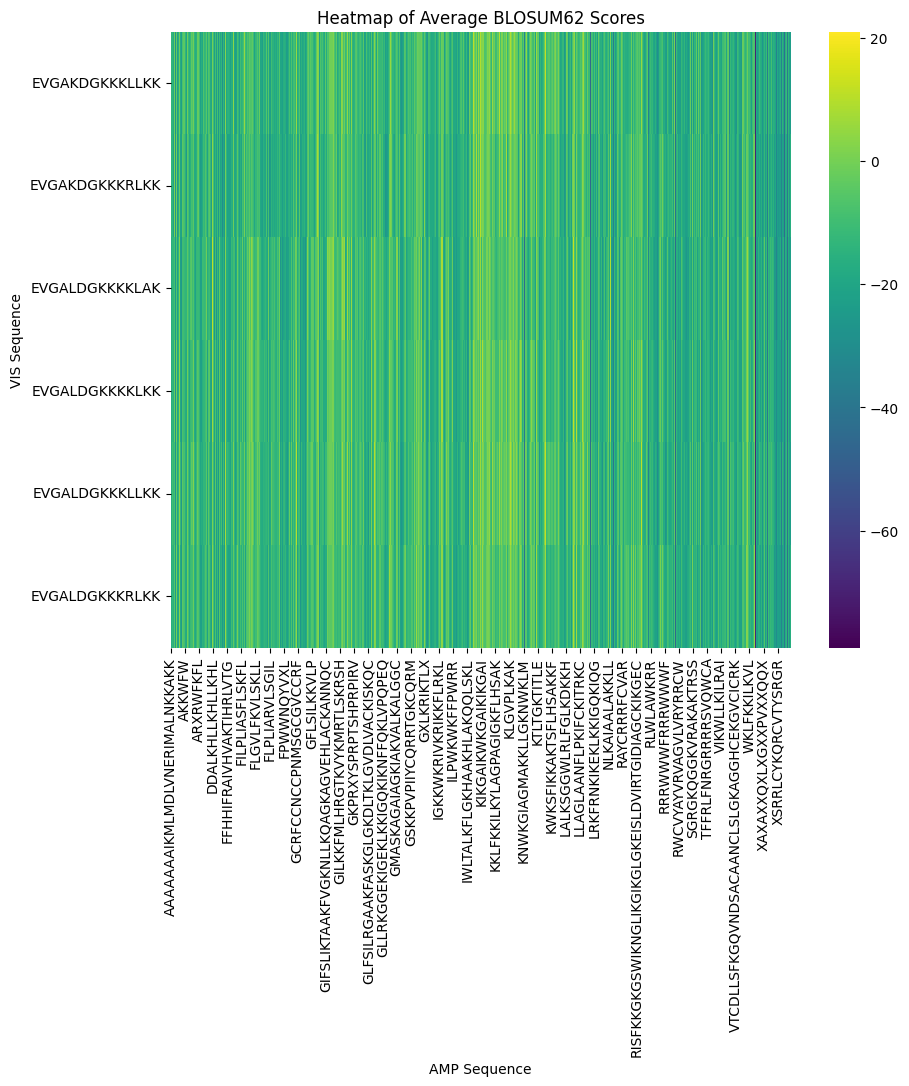

In [38]:
df = results_df
agg_df = df.groupby(['VIS_Sequence', 'AMP_Sequence']).BLOSUM62_Score.mean().reset_index()

# Pivot the DataFrame
pivot_df = agg_df.pivot_table(index='VIS_Sequence', columns='AMP_Sequence', values='BLOSUM62_Score')

# Create the heatmap
plt.figure(figsize=(10, 8))  # Adjust the size as needed
sns.heatmap(pivot_df, annot=False, cmap="viridis")  # Choose a suitable color palette
plt.title("Heatmap of Average BLOSUM62 Scores")
plt.xlabel("AMP Sequence")
plt.ylabel("VIS Sequence")
plt.show()

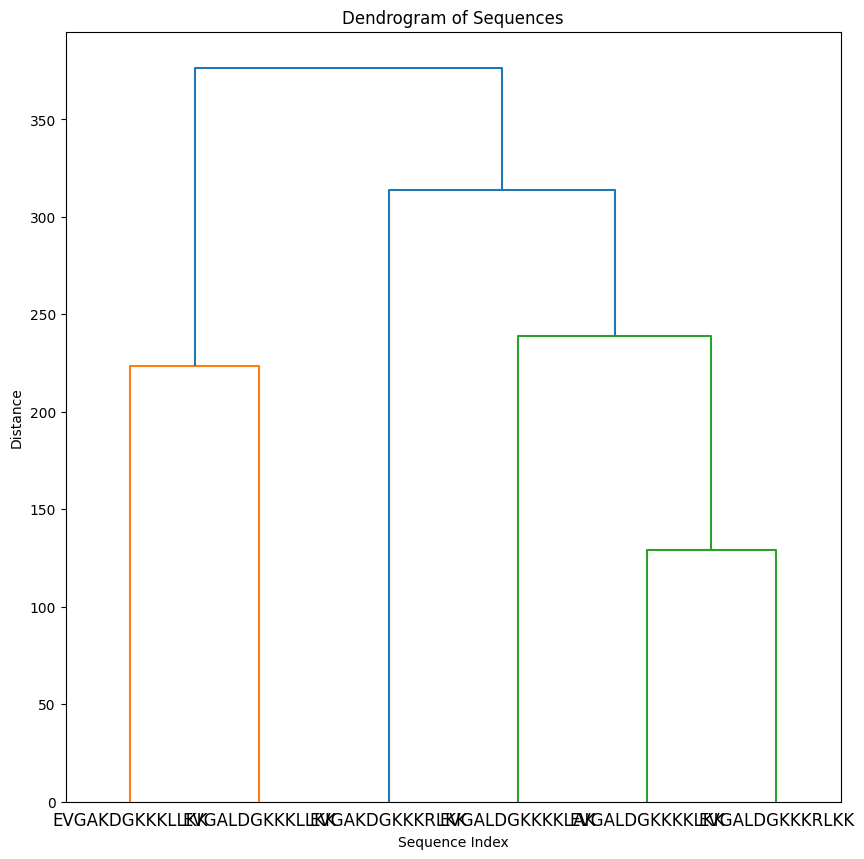

In [40]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Aggregate the duplicates
agg_df = df.groupby(['VIS_Sequence', 'AMP_Sequence']).BLOSUM62_Score.mean().reset_index()

# Convert to a pivot table
pivot_df = agg_df.pivot_table(index='VIS_Sequence', columns='AMP_Sequence', values='BLOSUM62_Score', fill_value=0)

# Convert scores to distances
max_score = pivot_df.values.max()
distance_matrix = max_score - pivot_df.values

# Perform hierarchical clustering
Z = linkage(distance_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 10))
dendrogram(Z, labels=pivot_df.index)
plt.title("Dendrogram of Sequences")
plt.xlabel("Sequence Index")
plt.ylabel("Distance")
plt.show()
